In [1]:
%matplotlib inline
import networkx as nx

# Chapter 3

Contents:

1. [Finding hubs](#Finding-hubs)
2. [Centrality distributions](#Centrality-distributions)
3. [Testing robustness](#Testing-robustness)


## 1. Finding hubs

Often when looking at a network, we want to find the most "important" nodes, for some definition of important. The most basic measure of centrality is the *degree*, or number of links attached to a node.

Let's look at the Enron executive email graph:

Name: 
Type: Graph
Number of nodes: 143
Number of edges: 623
Average degree:   8.7133


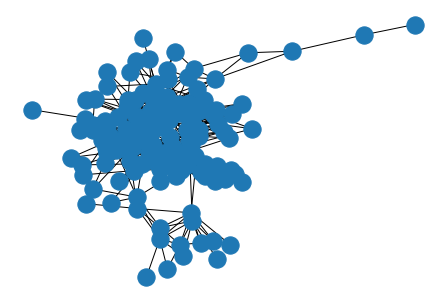

In [2]:
G = nx.read_edgelist('data/ia-enron-only.edges', nodetype=int)
print(nx.info(G))
nx.draw(G)

### Caveat: by default, `nx.read_edgelist` assumes node names are strings

Edge lists are a simple, plain text format for storing graphs. Since this simple file format doesn't contain information about data types, all node names are assumed to be strings by default. When the node names are given by integers, as they are in this example, we should specify the `nodetype=int` keyword argument to avoid confusion with the node names.


### Aside: the `max` function

We're going to make use of Python's built-in `max` function in order to find the node with the highest degree. 

First, let us recall what the `max` function does. At its most basic, the `max` function returns the "greatest" item in a sequence:

In [3]:
max([1,2,3,4,5])

5

But the "greatest" item is not always obvious:

In [4]:
max(['apple', 'grape', 'carrot'])

'grape'

Why is `grape` greater than the other options? Because the default sort for strings is lexicographical (basically alphabetical) order. If we don't want this default ordering, we can specify a *key* function, which tells Python how to compare the items:

In [5]:
max(['apple', 'grape', 'carrot'], key=len)

'carrot'

Now `carrot` is the greatest element, because we're comparing the items by their length.

### Finding the node with max degree

We can apply the `max` function to get the maximum node according to some criterion. In our case, we want to compare the nodes by their degree:

In [6]:
highest_degree_node = max(G.nodes, key=G.degree)
highest_degree_node

105

In [7]:
G.degree(highest_degree_node)

42

So we know that node `105` has 42 edges connected to it. Let's look at that calculation a little closer:

```python
max(G.nodes, key=G.degree)
```

We're telling the `max` function that we want the item from `G.nodes` that gives us the highest value when passed to the *key* function `G.degree`.

This construction works because `G.degree` is a function. Some other measures of centrality such as betweenness generate all of the nodes' centrality values at once and return a `dict`. In this case, we need an extra step:

In [8]:
betweenness = nx.centrality.betweenness_centrality(G)
highest_betweenness_node = max(G.nodes, key=betweenness.get)
highest_betweenness_node

105

In [9]:
betweenness[highest_betweenness_node]

0.19400604344556296

Note that the following will throw an error:

In [10]:
max(G.nodes, key=betweenness)

TypeError: 'dict' object is not callable

In [11]:
max(G.nodes, key=betweenness.get)

105

This is because we need to provide a function to the `key` argument, but `betweenness` is a dict. To get around this, we use the dict's `get` method.

## 2. Centrality distributions

We've found the most central node in the network, but often we want to summarize information about the centrality of all nodes. For example, in addition to the maxmimum degree, we often want the mean and median degree in a network.

The first step in summarizing this information is to get a sequence of all of the centrality values in the graph. We don't care about the node names anymore, we just want a sequence of numbers. We can start with the example of degree:

In [12]:
degree_sequence = [G.degree(n) for n in G.nodes]

To get the mean and median of this sequence, we can use Python's built-in `statistics` module:

In [13]:
import statistics

print('Mean degree:', statistics.mean(degree_sequence))
print('Median degree:', statistics.median(degree_sequence))

Mean degree: 8.713286713286713
Median degree: 8


For other measures of centrality, which are calculated for the whole network at once and return a dict, we can use the dict's `.values()`.

In [14]:
betweenness = nx.centrality.betweenness_centrality(G)
betweenness_sequence = list(betweenness.values())

print('Mean betweenness:', statistics.mean(betweenness_sequence))
print('Median betweenness:', statistics.median(betweenness_sequence))

Mean betweenness: 0.013950388838012454
Median betweenness: 0.0037492834763570323


Now that we have both degree and betweenness centrality, we could try to test their relationship using Pearson correlation. 

### EX1. Pearson correlation
hint: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pearsonr.html

In [15]:
import scipy.stats
# please write your code here
scipy.stats.pearsonr(degree_sequence, betweenness_sequence)

(0.7523994692957013, 2.4178781372473016e-27)

### Plotting the distribution

We can graphically represent the sequence of centrality values by using a *histogram*. In its basic form, a histogram plots the degree values on the x-axis, and the number of nodes having that degree on the y-axis. To do this counting, we can make use of Python's `collections.Counter`.

In [16]:
from collections import Counter

degree_counts = Counter(degree_sequence)
degree_counts

Counter({30: 1,
         2: 16,
         17: 5,
         12: 5,
         13: 3,
         16: 5,
         10: 9,
         11: 10,
         18: 3,
         20: 1,
         15: 3,
         19: 2,
         7: 9,
         14: 6,
         9: 16,
         42: 1,
         8: 6,
         5: 8,
         6: 7,
         1: 6,
         4: 11,
         23: 1,
         3: 9})

The `Counter` object returned is like a dict, pairing the item counted with the number of times it showed up in the sequence.

On this basic histogram plot, we want an x-value for every integer between the minimum and maximum degree in the sequence, inclusive. Note that `degree_counts.keys()` gives us every distinct value seen in the degree sequence. Also note that we need the +1 in the `range` below because we want to include the right endpoint.

In [17]:
min_degree, max_degree = min(degree_counts.keys()), max(degree_counts.keys())

plot_x = list(range(min_degree, max_degree + 1))

Our y-values are then the number of times we counted each x-value in the degree sequence. We can make use of the `.get` method with a default value in order to count 0 for degree values that don't show up in the sequence. For example, notice that 32 does not show up in `degree_counts` above, so `degree_counts.get(32, 0)` will give us 0.

In [18]:
plot_y = [degree_counts.get(x, 0) for x in plot_x]

To do the plotting, we use Matplotlib's `pyplot` module.

<BarContainer object of 42 artists>

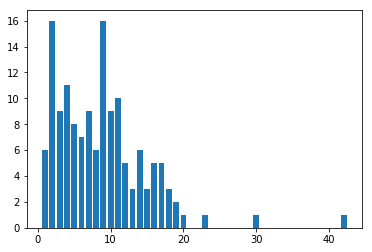

In [19]:
import matplotlib.pyplot as plt

plt.bar(plot_x, plot_y)

<BarContainer object of 23 artists>

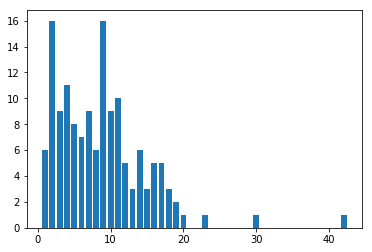

In [20]:
# option 2
plt.bar(degree_counts.keys(), degree_counts.values())

### Histogram binning

When there are more x-values than you can comfortably display, or when your centrality measure is not discrete, as in the case of betweenness centrality, we can make use of histogram "binning." This just defines a sequence of disjoint intervals called *bins*, and counts the number of values that fall into each such bin. In the simplest of cases, we can just tell Pyplot's `hist` function how many bins we want and it will do the binning for us.

In [21]:
betweenness_sequence[:10]

[0.11088210445609471,
 0.0003340978665026238,
 0.05833907970763193,
 0.0006787989625523211,
 0.0037576779169544673,
 0.006984623939369158,
 0.007284328058569526,
 0.0018837796140877582,
 0.001006133922375674,
 0.027382413977465946]

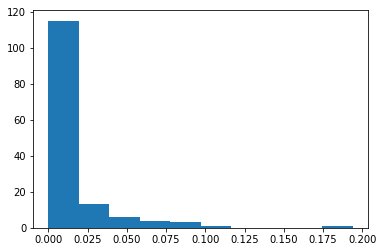

In [22]:
counts, bins, patches = plt.hist(betweenness_sequence, bins=10)

We can investigate the returned `bins` and `counts` if we want:

In [23]:
bins

array([0.        , 0.0194006 , 0.03880121, 0.05820181, 0.07760242,
       0.09700302, 0.11640363, 0.13580423, 0.15520483, 0.17460544,
       0.19400604])

In [24]:
counts

array([115.,  13.,   6.,   4.,   3.,   1.,   0.,   0.,   0.,   1.])

From these, we can see that there are 115 values between 0 and 0.0194006, 13 values between 0.194006 and 0.3880121, etc.

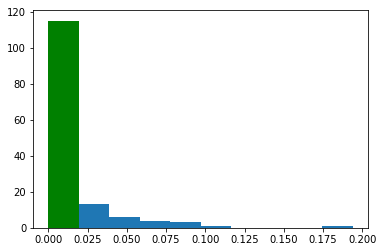

In [25]:
counts, bins, patches = plt.hist(betweenness_sequence, bins=10)
plt.setp(patches[0], 'facecolor', 'g')
plt.show()

## 3. Friendship paradox

Now that we know the distribution of node degrees, we can start testing Friendship paradox. The idea is simple. First, we calcuate the average number of friends an individual has, namely the average degree of the network ; and then we get the average amount of friends of a friend of the individual, in other words, the average degree of the neighbor nodes. The second value should be no less than the first value.

### EX2. testing friendship paradox

In [26]:
# please write your code here
import numpy as np
mean_deg = statistics.mean(degree_sequence)
avg_avg_nd = [] 
for node in G.nodes():
    avg_neighbor_degree = np.array([G.degree(n) for n in G.neighbors(node)]).mean()
    avg_avg_nd.append(avg_neighbor_degree)
avg_avg_nd = sum(avg_avg_nd)/len(G.nodes)
print(f'For network avg degree is {mean_deg}  and neighbors avg deg is {avg_avg_nd}')

For network avg degree is 8.713286713286713  and neighbors avg deg is 12.628394314885956


In [27]:
# Vishal's solution
mean_deg = statistics.mean(degree_sequence)
avg_neigh_deg = 0
for node in G.nodes():
    neigh_deg = 0
    for neigh in G.neighbors(node):
        neigh_deg += (G.degree(neigh))
    avg_neigh_deg += (neigh_deg/len(list(G.neighbors(node))))
avg_neigh_deg = avg_neigh_deg/len(G.nodes)
print(f'For network avg degree is {mean_deg}  and neighbors avg deg is {avg_neigh_deg}')

For network avg degree is 8.713286713286713  and neighbors avg deg is 12.628394314885956


## 4. Testing robustness

Another way to think about the relative "importance" of nodes in a network is to measure how much it would damage the network structure if particular nodes were to be removed. In real life, node removal might be a person moving away and out of a social network, someone changing jobs and being removed from an email network, internet routers being attacked/overloaded and going down, etc.

Broadly, we consider two types of network damage: random failure and targeted attack. In a random failure, nodes are chosen randomly for removal. In a targeted attack, we will remove nodes based on some criterion, for example, removing nodes in decreasing order of their degree centrality.

### Connected components

In order to measure "damage," we will measure the size of the network's largest connected component, sometimes called *core*. First we observe that `nx.connected_components` is a generator that provides the connected components one at a time, starting with the largest.

In [28]:
nx.connected_components(G)

<generator object connected_components at 0x7fb06010f4f8>

Since we often only want the core, or largest connected component, we can use the `next` function to get just the first item from the generator. Each component is provided as a set of node names:

In [29]:
core = next(nx.connected_components(G))
core

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143}

So the `len` of this set gives us the number of nodes in this component:

In [30]:
len(core)

143

In [31]:
len(G.nodes)

143

In [32]:
nx.is_connected(G)

True

If we want all of the connected components, we can get a list of them:

In [33]:
components = list(nx.connected_components(G))

the length of this list is the number of connected components:

In [34]:
len(components)

1

### Random failure

Whenever we're going to engage in a distructive process, we want to make a copy of the network graph to attack so that we can easily get back to the original state:

In [35]:
C = G.copy()

To simulate random failure, we randomly choose some node names and remove them from the graph. We can use `random.sample` to remove more than one node at at time. Note that we need to make a `list` of node names from which to randomly sample:

In [36]:
import random

nodes_to_remove = random.sample(list(C.nodes), 2)
print(nodes_to_remove)
C.remove_nodes_from(nodes_to_remove)
print(len(C.nodes))

[113, 95]
141


The full simulation is going to work like this, beginning from a fresh copy of the network:

1. Measure size of the network core as compared to the original network size
2. Select M nodes at random and remove them
3. Repeat until there are less than M nodes

We'll determine M from how many steps we want this process to take. Around 25 steps should be good, so:

In [37]:
10//3

3

In [38]:
number_of_steps = 25
M = G.number_of_nodes() // number_of_steps
M

5

We can then use `range` to generate a sequence of the total number of nodes removed at each step:

In [39]:
num_nodes_removed = range(0, G.number_of_nodes(), M)

In [40]:
list(num_nodes_removed)

[0,
 5,
 10,
 15,
 20,
 25,
 30,
 35,
 40,
 45,
 50,
 55,
 60,
 65,
 70,
 75,
 80,
 85,
 90,
 95,
 100,
 105,
 110,
 115,
 120,
 125,
 130,
 135,
 140]

In [41]:
len(num_nodes_removed)

29

The loop is fairly simple. At each step, we need to record the fraction of remaining nodes in the core.

In [42]:
N = G.number_of_nodes()
# USE THE COPY!
C = G.copy()

random_attack_core_proportions = []

for nodes_removed in num_nodes_removed:
    # Measure the relative size of the network core
    core = next(nx.connected_components(C))
    
    core_proportion = len(core) / N # "damage" measurement
    
    random_attack_core_proportions.append(core_proportion)
    
    # If there are more than M nodes, select M nodes at random and remove them
    if C.number_of_nodes() > M:
        
        nodes_to_remove = random.sample(list(C.nodes), M)
        
        C.remove_nodes_from(nodes_to_remove)

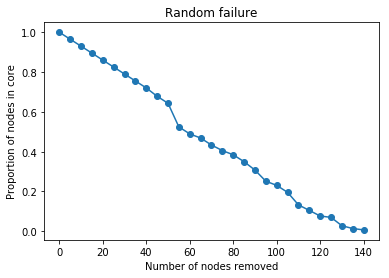

In [43]:
plt.title('Random failure')
plt.xlabel('Number of nodes removed')
plt.ylabel('Proportion of nodes in core')
plt.plot(num_nodes_removed, random_attack_core_proportions, marker='o')

#### Targeted attack

Simulating a targeted attack is similar, except that instead of choosing randomly, we will select the M most central nodes at each step. To accomplish this we want something like the `max` function used earler to get the most central node, but able to get the top M nodes. We can use Python's `sorted` function in a similar way to `max` to first sort the nodes by centrality in descending, or reverse, order. Once sorted by degree, we take the first M nodes in the list:

In [44]:
nodes_sorted_by_degree = sorted(G.nodes, key=G.degree, reverse=True)
top_degree_nodes = nodes_sorted_by_degree[:M]
top_degree_nodes

[105, 17, 95, 48, 132]

In [45]:
G.degree(top_degree_nodes)

DegreeView({105: 42, 17: 30, 95: 23, 48: 20, 132: 19})

With that in mind, the loop looks similar. Let's put all the pieces together here:

In [46]:
N = G.number_of_nodes()
number_of_steps = 25
M = N // number_of_steps

num_nodes_removed = range(0, N, M)
C = G.copy()
targeted_attack_core_proportions = []
for nodes_removed in num_nodes_removed:
    # Measure the relative size of the network core
    core = next(nx.connected_components(C))
    core_proportion = len(core) / N
    targeted_attack_core_proportions.append(core_proportion)
    
    # If there are more than M nodes, select top M nodes and remove them
    if C.number_of_nodes() > M:
        nodes_sorted_by_degree = sorted(C.nodes, key=C.degree, reverse=True)
        nodes_to_remove = nodes_sorted_by_degree[:M]
        C.remove_nodes_from(nodes_to_remove)

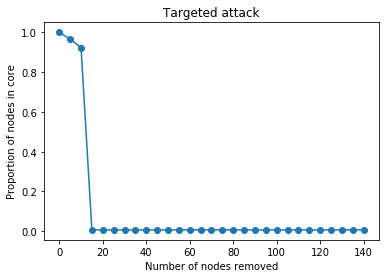

In [47]:
plt.title('Targeted attack')
plt.xlabel('Number of nodes removed')
plt.ylabel('Proportion of nodes in core')
plt.plot(num_nodes_removed, targeted_attack_core_proportions, marker='o')

As we can see, the effect is dramatic. The network is totally disconnected after removing relatively few central nodes in the graph.

Pyplot can plot these curves on the same plot for additional effect:

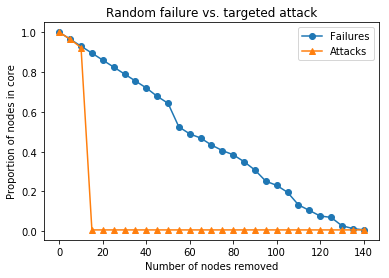

In [48]:
plt.title('Random failure vs. targeted attack')
plt.xlabel('Number of nodes removed')
plt.ylabel('Proportion of nodes in core')
plt.plot(num_nodes_removed, random_attack_core_proportions, marker='o', label='Failures')
plt.plot(num_nodes_removed, targeted_attack_core_proportions, marker='^', label='Attacks')
plt.legend()

In [49]:
num_nodes_removed

range(0, 143, 5)